In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dummy_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

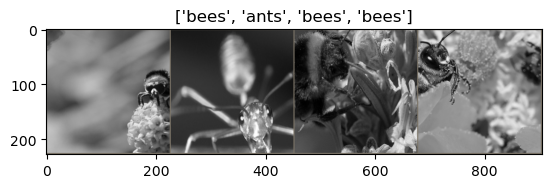

In [22]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [6]:
model_152 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
num_ftrs = model_152.fc.in_features
num_ftrs

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/tadeusz/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [02:01<00:00, 1.99MB/s] 


2048

In [7]:
model_152.fc = nn.Linear(num_ftrs,2)
model_152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_152 = optim.SGD(model_152.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_152, step_size=7, gamma=0.1)

In [17]:
model_152 = train_model(model_152, criterion, optimizer_152, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.2879 Acc: 0.9057
val Loss: 0.2072 Acc: 0.9739

Epoch 2/25
----------
train Loss: 0.2961 Acc: 0.8893
val Loss: 0.2175 Acc: 0.9608

Epoch 3/25
----------
train Loss: 0.2479 Acc: 0.9221
val Loss: 0.2117 Acc: 0.9673

Epoch 4/25
----------
train Loss: 0.2812 Acc: 0.8852
val Loss: 0.2067 Acc: 0.9739

Epoch 5/25
----------
train Loss: 0.2885 Acc: 0.8975
val Loss: 0.1937 Acc: 0.9804

Epoch 6/25
----------
train Loss: 0.2853 Acc: 0.8852
val Loss: 0.2223 Acc: 0.9542

Epoch 7/25
----------
train Loss: 0.2656 Acc: 0.9098
val Loss: 0.2223 Acc: 0.9608

Epoch 8/25
----------
train Loss: 0.2570 Acc: 0.8975
val Loss: 0.2076 Acc: 0.9673

Epoch 9/25
----------
train Loss: 0.3078 Acc: 0.8730
val Loss: 0.2186 Acc: 0.9673

Epoch 10/25
----------
train Loss: 0.2822 Acc: 0.8975
val Loss: 0.2018 Acc: 0.9804

Epoch 11/25
----------
train Loss: 0.2586 Acc: 0.9098
val Loss: 0.2050 Acc: 0.9673

Epoch 12/25
----------
train Loss: 0.3307 Acc: 0.8402
val Loss: 0.1954 Acc: 0.9739

E

In [18]:
torch.save(model_152, 'dummy_data/resnet152_bees_ants_model')

In [ ]:
# looking at the accuracy if only 1 channel is given to the network

In [16]:
for x in ['train', 'val']

dummy_data/hymenoptera_data/huh/huh.txt/loool
